# Model Selection

In [1]:
# Import libraries
# type: ignore
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Imbalance datasets
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Linear model
from sklearn.linear_model import LogisticRegression

# Non-linear model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Tree-based model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix

In [2]:
# Read data
def read_data(filename):
    X = pd.read_csv(f"../Data/process/{filename}_transform.csv", header=0)
    return X

# Save model
def save_model(filename, model):
    with open(f"../Model/{filename}.pkl", 'wb') as f:
        pickle.dump(model, f)

In [3]:
# Read transformed training data
train_df = read_data('train')
valid_df = read_data('valid') # Validation data

# View
train_df.head()

,credit_score,age,tenure,num_of_products,balance,salary,age_label_proportion,avg_credit_score_by_age,geography_france,geography_germany,...,is_active_member,age_young,age_old,zero_balance,new_customer,old_customer,single_product,mt3_product,is_female,churn
0,-0.694374,0.480890,-0.009572,0.797297,0.295612,0.124178,-0.399331,-1.187795,1,0,...,1,0,0,0,0,0,0,0,1,0
1,-2.049957,-0.091560,1.022171,-0.913029,0.696248,0.528050,1.003343,0.129728,0,1,...,0,0,0,0,0,0,1,0,1,0
2,1.571829,0.385481,-0.697401,-0.913029,-1.240550,-0.478379,-0.399331,-1.187795,0,0,...,0,0,0,1,0,0,1,0,0,0
3,-0.518459,0.194665,-0.697401,0.797297,-1.240550,-0.787547,-0.399331,-1.187795,0,0,...,0,0,0,1,0,0,0,0,1,0
4,-1.242816,0.290073,0.334342,0.797297,0.177637,-0.422558,-0.399331,-1.187795,0,1,...,0,0,0,0,0,0,0,0,1,0


In [4]:
# target distribution
train_df['churn'].value_counts()

churn
0    4777
1    1223
Name: count, dtype: int64

- *The given dataset has imbalance class distribution.*

In [5]:
# Separate features and target variables.
X_train = train_df.drop(['churn'], axis=1).copy()
X_valid = valid_df.drop(['churn'], axis=1).copy()

y_train = train_df['churn']
y_valid = valid_df['churn']

### Handle Imbalance Dataset

Handle imbalance class distribution in dataset by adjusting class-weights.

In [6]:
# Compute weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = dict(zip(np.unique(y_train), class_weights))
weights_dict

{np.int64(0): np.float64(0.6280092108017584),
 np.int64(1): np.float64(2.4529844644317254)}

In [7]:
def evaluate_cross_validation(models, X, y):
    # Perform 10-fold cross-validation to select the best model.
    scores = []
    for name, model in models:
        CV = StratifiedKFold(10)
        score = cross_val_score(model, X, y, scoring='recall', cv=CV, n_jobs=-1)
        scores.append((name, score.mean()))
        print("%s ==> %.3f +-(%.2f)" %(name, score.mean(), score.std()))
        
    return scores

In [8]:
# List of machine learning classification alogrithms
models = []
models.append(('LR', LogisticRegression(class_weight=weights_dict, random_state=42)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Naive', GaussianNB()))
models.append(('SVM', SVC(random_state=42, class_weight=weights_dict)))
models.append(('CART', DecisionTreeClassifier(random_state=42, class_weight=weights_dict)))
models.append(('RF', RandomForestClassifier(random_state=42, class_weight=weights_dict)))
models.append(('GB', GradientBoostingClassifier(random_state=42)))
models.append(('XGB', XGBClassifier(random_state=42, class_weight=weights_dict)))

In [9]:
# Model performance with default setting
model_scores = evaluate_cross_validation(models, X_train, y_train)

# Save results in dataframe
model_scores_df = pd.DataFrame(model_scores, columns=['Classifier', 'Recall'])

LR ==> 0.746 +-(0.04)
KNN ==> 0.411 +-(0.05)
Naive ==> 0.119 +-(0.03)
SVM ==> 0.749 +-(0.04)
CART ==> 0.473 +-(0.05)
RF ==> 0.417 +-(0.06)
GB ==> 0.455 +-(0.03)
XGB ==> 0.484 +-(0.05)


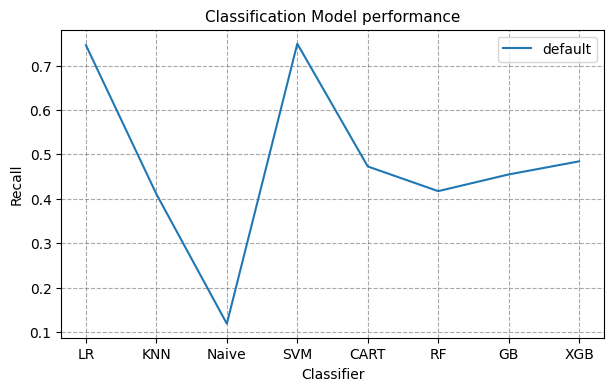

In [11]:
# Model perfromance visualization
fig = plt.figure(figsize=(7, 4))
sns.lineplot(model_scores_df, x='Classifier', y='Recall', label='default')
plt.grid(ls='--', color='#555', alpha=0.5)
plt.title("Classification Model performance", size=11);

- *Resampling along with Class weights significantly improves the performance of the models, Along with tree-based classifier, KNN perform very well.*
- *Random forest Classifier outperforms other classifier with highest f1-score 0.96.*

### Model Optimization

Let's further evaluate the classifier model using GridSearch cross-validation method to find the optimal model that perform good on validation data.

For that, we are going to select classifier based on above cross-validation score. 
- Logistic Regression
- KNearest Classifier
- Gradient Boosting Classifier
- XGBoost Classifier
- Random Forest Classifer

In [17]:
# Functions to evalaute the model using GridSearch algorithm
def get_search_score(y_true, y_preds_proba, threshold=0.5):
    # Convert predictions into 0 and 1 based on threshold
    y_preds = (y_preds_proba > threshold).astype(int)
    
    # Display confusion matrix
    cm = confusion_matrix(y_true, y_preds)
    
    # Precision, Recall, F1-Score
    precision, recall, f1score, support = precision_recall_fscore_support(y_true, y_preds, average='macro')
    return precision, recall, f1score, cm


def evaluate_search_model(model, name):
    
    # Fit the model on training data
    model.fit(X_train, y_train)

    try:
        # Make predictions
        y_train_preds = model.predict_proba(X_train)[:, 1]
        y_valid_preds = model.predict_proba(X_valid)[:, 1]

    except:
        # Make predictions
        y_train_preds = model.predict(X_train)
        y_valid_preds = model.predict(X_valid)

    # Compute score
    t_roc = roc_auc_score(y_train, y_train_preds)
    v_roc = roc_auc_score(y_valid, y_valid_preds)
 
    t_precision, t_recall, t_f1score, t_cm= get_search_score(y_train, y_train_preds)
    v_precision, v_recall, v_f1score, v_cm = get_search_score(y_valid, y_valid_preds)

    # Convert results into DataFrame
    train_scores = [t_roc, t_precision, t_recall, t_f1score]
    valid_scores = [v_roc, v_precision, v_recall, v_f1score]
    
    clf_score_df = pd.DataFrame(
                            data = {
                                'training_score': train_scores,
                                'validation_score' : valid_scores
                            },
                            index = ['roc-auc-score', 'precision', 'recall', 'f1-score']
                        )

    # Add classifier score into scoring dataframe.
    score_df.loc[len(score_df)] = [name] + train_scores + valid_scores
    
    return model, clf_score_df, v_cm

In [13]:
# Define the score dataframe that stores the metrics score for each model.
score_df = pd.DataFrame(
    columns = ['Classifier',
               'Train-ROC-AUC', 'Train Precision', 'Train Recall', 'Train F1Score',
               'Valid-ROC-AUC', 'Valid Precision', 'Valid Recall', 'Valid F1Score']
)

In [14]:
# define function to plot learning curves
def plot_learning_curve(best_score, clf_score_df):
    # Set figure size
    fig = plt.figure(figsize=(7, 4))
   
    # line plot
    sns.lineplot(clf_score_df, x=clf_score_df.index, y='training_score', label='Training')
    sns.lineplot(clf_score_df, x=clf_score_df.index, y='validation_score', label='Validation')
    
    # Add labels
    plt.xlabel('Metrics')
    plt.ylabel('Recall Score')
    plt.title(f"Training vs. Validation scores (Best score={best_score:.2f})", size=11)

    plt.ylim(ymin=0, ymax=1.1)
    plt.grid(ls='--', color='#555', alpha=0.5)
    plt.legend();

### Logistic Regression

In [15]:
# Define Logisitic Regression Model
LR_clf = LogisticRegression(solver='liblinear', class_weight=weights_dict, random_state=42)

In [18]:
# Set GridSearch to find best model
params = {
    'max_iter': [100, 500, 1000, 1500],
    'C' : np.linspace(0.0001, 1, num=10),
    'penalty': ['l2', None]
}

# Grid Search algorithm
LR_search_clf = GridSearchCV(estimator=LR_clf,
                             param_grid=params,
                             scoring='recall',
                             cv=StratifiedKFold(7, shuffle=True, random_state=42),
                             n_jobs=-1,
                             verbose=1,
                             return_train_score=True)

# Fit model on training data
LR_search_clf.fit(X_train, y_train)

Fitting 7 folds for each of 80 candidates, totalling 560 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight={np.int64(0): np.float64(0.6280092108017584),
                                                        np.int64(1): np.float64(2.4529844644317254)},
                                          random_state=42, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.000e-04, 1.112e-01, 2.223e-01, 3.334e-01, 4.445e-01, 5.556e-01,
       6.667e-01, 7.778e-01, 8.889e-01, 1.000e+00]),
                         'max_iter': [100, 500, 1000, 1500],
                         'penalty': ['l2', None]},
             return_train_score=True, scoring='recall', verbose=1)

In [19]:
# GridSearch results
LR_CVresults = pd.DataFrame(LR_search_clf.cv_results_).dropna()
columns = ['mean_fit_time', 'mean_score_time', 
           'param_C', 'param_max_iter', 'param_penalty',
           'mean_train_score', 'mean_test_score']
LR_CVresults = LR_CVresults[columns]
LR_CVresults.head()

,mean_fit_time,mean_score_time,param_C,param_max_iter,param_penalty,mean_train_score,mean_test_score
0,0.023002,0.006859,0.0001,100,l2,0.678250,0.675384
2,0.022430,0.007715,0.0001,500,l2,0.678250,0.675384
4,0.017287,0.006715,0.0001,1000,l2,0.678250,0.675384
6,0.017858,0.007858,0.0001,1500,l2,0.678250,0.675384
8,0.038574,0.007429,0.1112,100,l2,0.756882,0.751443


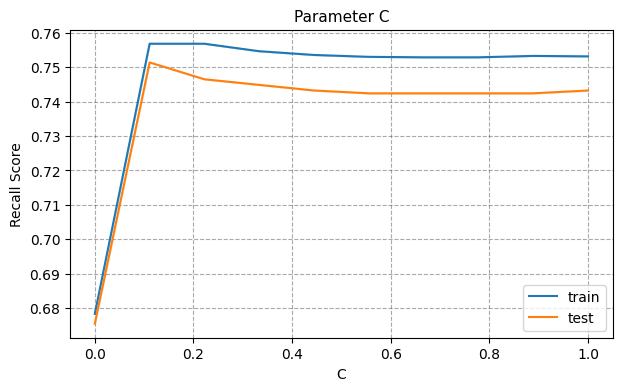

In [20]:
# Examine the logisitic Regression scores across different values of parameter C.
plt.figure(figsize=(7, 4))

sns.lineplot(LR_CVresults, x='param_C', y='mean_train_score', label='train')
sns.lineplot(LR_CVresults, x='param_C', y='mean_test_score', label='test')

# Add labels
plt.xlabel('C')
plt.ylabel('Recall Score')
plt.title("Parameter C", size=11)

plt.grid(ls='--', color='#555', alpha=0.5)
plt.legend();

#### Best Model Evaluation on validation - Logistic Regession

In [21]:
# Save best model
LR_best_clf = LR_search_clf.best_estimator_

# Evaluate the best classifer
LR_model, LR_score, LR_confusion_matrix = evaluate_search_model(LR_best_clf, 'Logistic Regression')

In [22]:
score_df

,Classifier,Train-ROC-AUC,Train Precision,Train Recall,Train F1Score,Valid-ROC-AUC,Valid Precision,Valid Recall,Valid F1Score
0,Logistic Regression,0.847319,0.697519,0.769379,0.71297,0.836706,0.689985,0.758955,0.70457


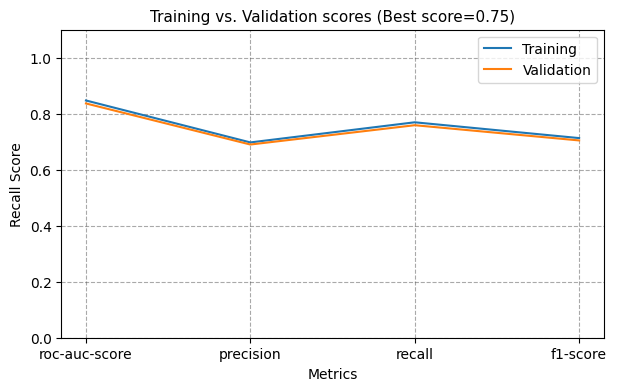

In [23]:
# Examine logistic regression performances on validation across different metrics
best_score = LR_search_clf.best_score_
plot_learning_curve(best_score, LR_score)

#### Precision Recall Curve 
To find optimal threshold value

In [26]:
# Find optimal threshold value
def find_threshold(model):
    # Make prediction using model
    y_preds = model.predict_proba(X_valid)[:, -1]
    
    # plot precision-recall curve
    precision, recall, threshold = precision_recall_curve(y_valid, y_preds)

    # Compute the f1-score
    threshold_df = pd.DataFrame(data={
        'precision': precision[:-1],
        'recall': recall[:-1], 
        'threshold': threshold
    })
    
    threshold_df['f1score'] = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
    best_threshold = threshold_df.nlargest(1, 'f1score')['threshold'].values[0]
    
    # Plot precision-recall trade-off curve
    fig=plt.figure(figsize=(7, 4))
    plt.plot(precision, recall)
    
    # Add labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Trade-off", size=11)
    plt.grid(ls='--', color='#555', alpha=0.5)
    plt.show()
    
    return best_threshold, y_preds

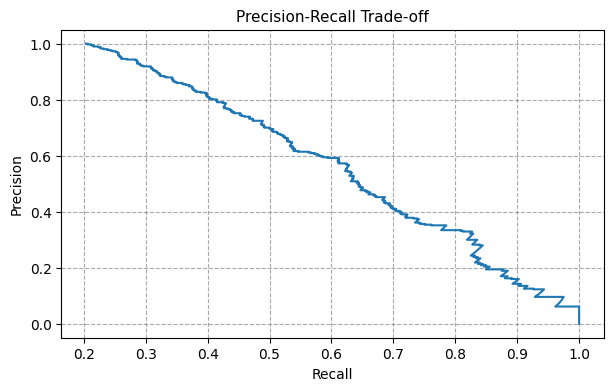

Best of Logistic Regression
------------------------------
Precision:: 0.7533833372126717
Recall:: 0.7468176959702384
F1-score:: 0.75
Confusion Matrix::
---------------
[[1440  153]
 [ 167  240]]


In [27]:
# Find the best threshold for Logistic Regression
best_threshold, y_preds = find_threshold(LR_model)

# Examine scores with best threshold value.
precision, recall, f1score, cm = get_search_score(y_valid, y_preds, best_threshold)

print(f"Best of Logistic Regression\n{'---'*10}")
print("Precision::", precision)
print("Recall::", recall)
print("F1-score::", f1score)
print(f"Confusion Matrix::\n{'---'*5}")
print(cm)

In [28]:
# Save grid search Linear Regression
save_model('LR_model', LR_model)

### KNearest Neighbors

In [29]:
# Define KNN Classifier
KNN_clf = KNeighborsClassifier()

In [31]:
# Set GridSearch Parameters
params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 18, 21, 23]
}

# Define grid search for knn
KNN_search_clf = GridSearchCV(estimator=KNN_clf, 
                              param_grid=params, 
                              scoring='recall',
                              cv=StratifiedKFold(7, shuffle=True, random_state=42), 
                              n_jobs=-1, 
                              verbose=1, 
                              return_train_score=True)

# Fit the search algorithm on training data
KNN_search_clf.fit(X_train, y_train)

Fitting 7 folds for each of 9 candidates, totalling 63 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 15, 18, 21, 23]},
             return_train_score=True, scoring='recall', verbose=1)

In [32]:
# GridSearch results
KNN_CVresults = pd.DataFrame(KNN_search_clf.cv_results_).dropna()
columns = ['mean_fit_time', 'mean_score_time', 
           'param_n_neighbors', 'mean_train_score', 'mean_test_score']
KNN_CVresults = KNN_CVresults[columns]
KNN_CVresults.head()

,mean_fit_time,mean_score_time,param_n_neighbors,mean_train_score,mean_test_score
0,0.012286,0.158727,3,0.612976,0.420235
1,0.013000,0.177810,5,0.524799,0.406324
2,0.016430,0.184966,7,0.475195,0.389951
3,0.010143,0.205961,9,0.442078,0.371147
4,0.009857,0.194017,11,0.418504,0.361389


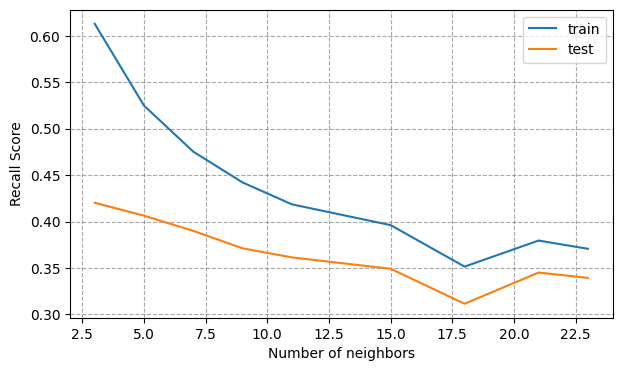

In [33]:
# Examine the logisitic Regression scores across different values of parameter C.
plt.figure(figsize=(7, 4))

sns.lineplot(KNN_CVresults, x='param_n_neighbors', y='mean_train_score', label='train')
sns.lineplot(KNN_CVresults, x='param_n_neighbors', y='mean_test_score', label='test')

# Add labels
plt.xlabel('Number of neighbors')
plt.ylabel('Recall Score')
plt.title("", size=11)

plt.grid(ls='--', color='#555', alpha=0.5)
plt.legend();

#### Best Model Evaluation - KNN

In [34]:
# Best model - knn
KNN_best_clf = KNN_search_clf.best_estimator_

# Evaluate the best classifer
KNN_model, KNN_score, KNN_confusion_matrix = evaluate_search_model(KNN_best_clf, 'KNN')

In [35]:
score_df

,Classifier,Train-ROC-AUC,Train Precision,Train Recall,Train F1Score,Valid-ROC-AUC,Valid Precision,Valid Recall,Valid F1Score
0,Logistic Regression,0.847319,0.697519,0.769379,0.712970,0.836706,0.689985,0.758955,0.704570
1,KNN,0.944583,0.857719,0.787688,0.815492,0.734269,0.698437,0.661190,0.675292


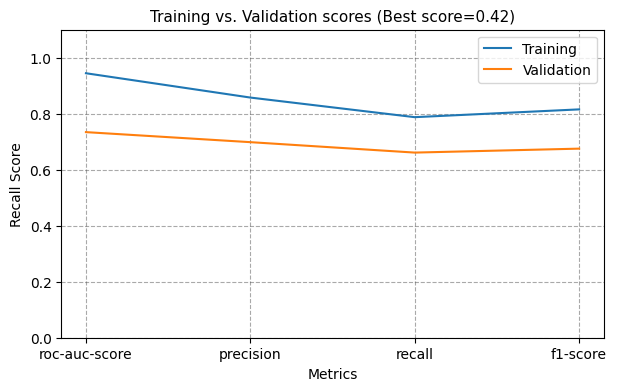

In [36]:
# Exmaine performance of K-nearest model to detect any overfitting present.
best_score = KNN_search_clf.best_score_
plot_learning_curve(best_score, KNN_score)

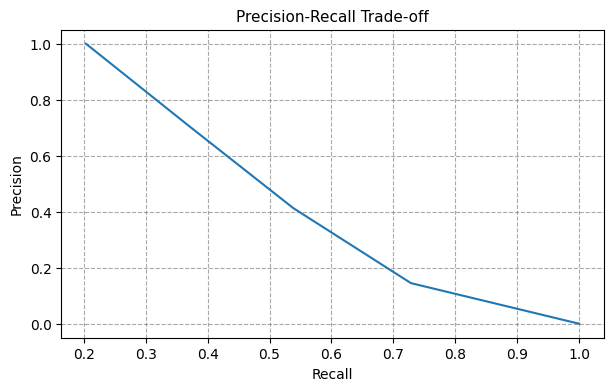

Best of K-Nearest Neighbors
------------------------------
Precision:: 0.698
Recall:: 0.661
F1-score:: 0.675
Confusion Matrix::
---------------
[[1449  144]
 [ 239  168]]


In [37]:
# Find the best threshold for Logistic Regression
KNN_best_threshold, y_preds = find_threshold(KNN_model)

# Examine scores with best threshold value.
precision, recall, f1score, cm = get_search_score(y_valid, y_preds, KNN_best_threshold)

print(f"Best of K-Nearest Neighbors\n{'---'*10}")
print("Precision:: %.3f" %precision)
print("Recall:: %.3f" %recall)
print("F1-score:: %.3f" %f1score)
print(f"Confusion Matrix::\n{'---'*5}")
print(cm)

In [38]:
# Save grid search K-nearest neighbor classifier
save_model('KNN_model', KNN_model)

### Gradient Boosting Classifier

In [39]:
# Define the gradient boost classifier
GBM_clf = GradientBoostingClassifier(max_features='sqrt', n_iter_no_change=30, validation_fraction=0.3, random_state=42)

In [40]:
# Set parameters for gradient boosting classifier
params = {
    'n_estimators' : [10, 100, 200, 250, 300, 500, 800, 1100, 1200],
    'learning_rate': [0.001, 0.01, 0.02, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.8]
}

# Define GridSearch for GBM
GBM_search_clf = GridSearchCV(estimator=GBM_clf,
                              param_grid=params,
                              scoring='recall',
                              n_jobs=-1,
                              cv=StratifiedKFold(7, shuffle=True, random_state=42),
                              verbose=1,
                              return_train_score=True)

# Fit the search algorithm on training data
GBM_search_clf.fit(X_train, y_train)

Fitting 7 folds for each of 324 candidates, totalling 2268 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_iter_no_change=30,
                                                  random_state=42,
                                                  validation_fraction=0.3),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.02, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [10, 100, 200, 250, 300, 500, 800,
                                          1100, 1200],
                         'subsample': [0.6, 0.7, 0.8]},
             return_train_score=True, scoring='recall', verbose=1)

In [41]:
# GridSearch results
GBM_CVresults = pd.DataFrame(GBM_search_clf.cv_results_).dropna()
columns = ['mean_fit_time', 'mean_score_time', 
           'param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_subsample', 
           'mean_train_score', 'mean_test_score']
GBM_CVresults = GBM_CVresults[columns]
GBM_CVresults.head()

,mean_fit_time,mean_score_time,param_n_estimators,param_learning_rate,param_max_depth,param_subsample,mean_train_score,mean_test_score
0,0.066290,0.009572,10,0.001,3,0.6,0.0,0.0
1,0.061576,0.007716,10,0.001,3,0.7,0.0,0.0
2,0.059148,0.006572,10,0.001,3,0.8,0.0,0.0
3,0.548760,0.011858,100,0.001,3,0.6,0.0,0.0
4,0.572476,0.010716,100,0.001,3,0.7,0.0,0.0


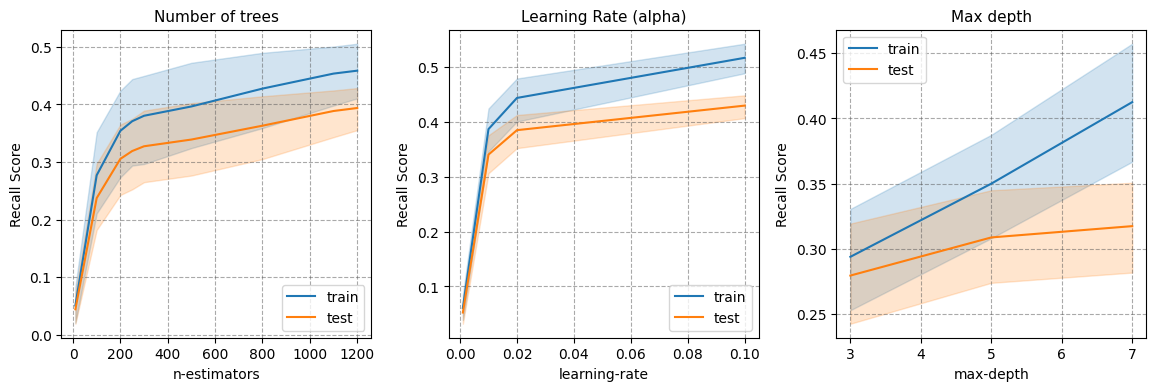

In [42]:
# Examine the training and validation scores over chaning parameter values.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
fig.subplots_adjust(wspace=0.25)

# plot
sns.lineplot(GBM_CVresults, x=f'param_n_estimators', y='mean_train_score', ax=ax1, label='train')
sns.lineplot(GBM_CVresults, x=f'param_n_estimators', y='mean_test_score', ax=ax1, label='test')

sns.lineplot(GBM_CVresults, x=f'param_learning_rate', y='mean_train_score', ax=ax2, label='train')
sns.lineplot(GBM_CVresults, x=f'param_learning_rate', y='mean_test_score', ax=ax2, label='test')

sns.lineplot(GBM_CVresults, x=f'param_max_depth', y='mean_train_score', ax=ax3, label='train')
sns.lineplot(GBM_CVresults, x=f'param_max_depth', y='mean_test_score', ax=ax3, label='test')

ax1.set_title("Number of trees", size=11)
ax2.set_title("Learning Rate (alpha)", size=11)
ax3.set_title("Max depth", size=11)

ax1.set_xlabel('n-estimators')
ax2.set_xlabel('learning-rate')
ax3.set_xlabel('max-depth')

ax1.set_ylabel('Recall Score')
ax2.set_ylabel('Recall Score')
ax3.set_ylabel('Recall Score')

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5)
ax3.grid(ls='--', color='#555', alpha=0.5)

ax1.legend()
ax2.legend()
ax3.legend();

#### Best Model Evaluation - Gradient Boosting Classifier

In [43]:
# Best model - knn
GBM_best_clf = GBM_search_clf.best_estimator_

# Evaluate the best classifer
GBM_model, GBM_score, GBM_confusion_matrix = evaluate_search_model(GBM_best_clf, 'Gradient Boosting Classifier')

In [44]:
score_df

,Classifier,Train-ROC-AUC,Train Precision,Train Recall,Train F1Score,Valid-ROC-AUC,Valid Precision,Valid Recall,Valid F1Score
0,Logistic Regression,0.847319,0.697519,0.769379,0.712970,0.836706,0.689985,0.758955,0.704570
1,KNN,0.944583,0.857719,0.787688,0.815492,0.734269,0.698437,0.661190,0.675292
2,Gradient Boosting Classifier,0.879720,0.832523,0.738524,0.771136,0.854610,0.814129,0.714870,0.747177


In [45]:
GBM_confusion_matrix

array([[1530,   63],
       [ 216,  191]])

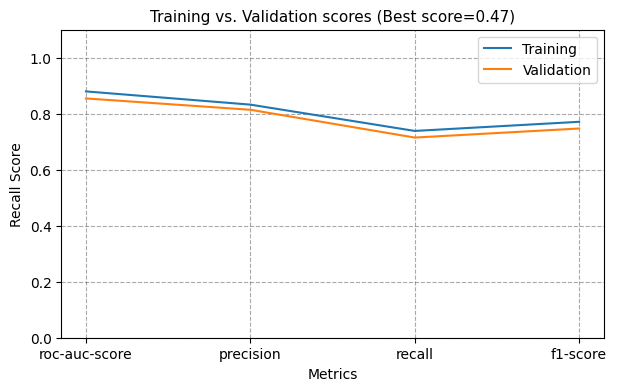

In [46]:
# Save the best model score
best_score = GBM_search_clf.best_score_
plot_learning_curve(best_score, GBM_score)

- *As parameter value increases the gap between roc-scores also increases indicating overfitting model.*
- *Next, evaluate model on validation data*

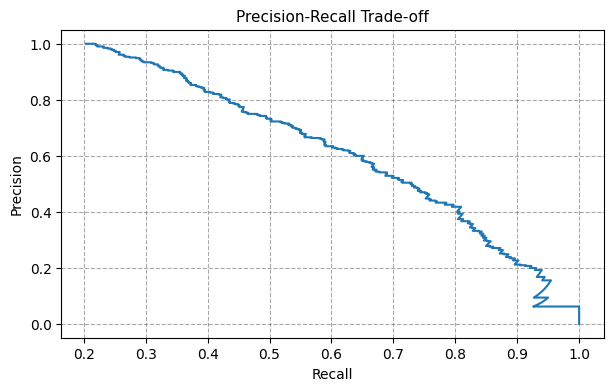

Best of Gradient Boosting Classifier
------------------------------
Precision:: 0.7753377571180695
Recall:: 0.757722283146012
F1-score:: 0.765886287625418
Confusion Matrix::
---------------
[[1463  130]
 [ 164  243]]


In [47]:
# Find the best threshold for Logistic Regression
GBM_best_threshold, y_preds = find_threshold(GBM_model)

# Examine scores with best threshold value.
precision, recall, f1score, cm = get_search_score(y_valid, y_preds, GBM_best_threshold)

print(f"Best of Gradient Boosting Classifier\n{'---'*10}")
print("Precision::", precision)
print("Recall::", recall)
print("F1-score::", f1score)
print(f"Confusion Matrix::\n{'---'*5}")
print(cm)

- *Gradient Boosting model seems to have good overall performance, especially in terms of ROC-AUC. However, lower recall indeicates that it might miss some positive cases.*
- *We are more interested in recall scores, as we dont wanna miss out any false negatives(actual positives), let's model evaluate further on percision-recall curve over different thresholds.*

- *We can see trade-off between precision and recall as the recall increases the precision dreasease.*
- *Let's find optimal value based on high f1 score, as f1-score balances precision and recall.*

- *It seems like 0.3 is good treshold values.*

In [48]:
# Save grid search gradient model
save_model('GBM_model', GBM_model)

### XGBoost Classifier

In [49]:
# Define the XGBoost classifier
XGB_clf = XGBClassifier(colsample_bytree=0.25, class_weight=weights_dict, random_state=42)

In [50]:
# Set parameters for GradientSearch algorithms
params = {
    'n_estimators': [100, 200, 300, 500, 800, 1100, 1200],
    'learning_rate': [0.001, 0.01, 0.1, 0.02],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.8]
}

# Define search algorithm
XGB_search_clf = GridSearchCV(estimator=XGB_clf,
                              param_grid=params,
                              scoring='recall',
                              n_jobs=-1,
                              cv=StratifiedKFold(7, shuffle=True, random_state=42),
                              verbose=1,
                              return_train_score=True)

# Fit the search algorithm on training data
XGB_search_clf.fit(X_train, y_train)

Fitting 7 folds for each of 252 candidates, totalling 1764 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None,
                                     class_weight={np.int64(0): np.float64(0.6280092108017584),
                                                   np.int64(1): np.float64(2.4529844644317254)},
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.25, device=None,
                                     early_stopping_rounds=None,
                                     en...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.02],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300, 500, 800, 1100, 1200],
                         'subsample': [0.6, 0.7, 0.8]},
             return_train_score=True, scoring='recall', verbose=1)

In [51]:
# Examine training & validation score from search algorithm
XGB_CVresults = pd.DataFrame(XGB_search_clf.cv_results_)
columns = ['mean_fit_time', 'mean_score_time', 
           'param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_subsample',
           'mean_train_score', 'mean_test_score']

XGB_CVresults = XGB_CVresults[columns]
XGB_CVresults.head()

,mean_fit_time,mean_score_time,param_n_estimators,param_learning_rate,param_max_depth,param_subsample,mean_train_score,mean_test_score
0,0.250305,0.029718,100,0.001,3,0.6,0.0,0.0
1,0.246447,0.029147,100,0.001,3,0.7,0.0,0.0
2,0.246877,0.028574,100,0.001,3,0.8,0.0,0.0
3,0.442360,0.031289,200,0.001,3,0.6,0.0,0.0
4,0.437337,0.030718,200,0.001,3,0.7,0.0,0.0


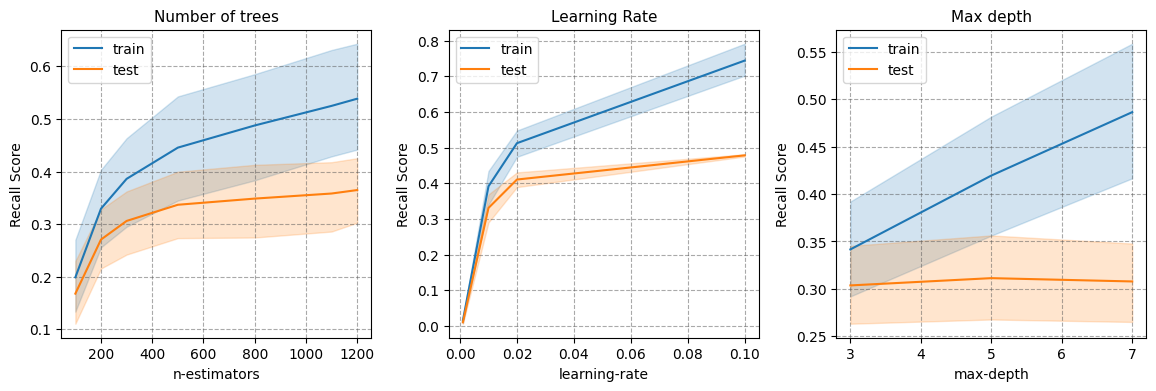

In [52]:
# Plot learning curves
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
fig.subplots_adjust(wspace=0.25)

# plot
sns.lineplot(XGB_CVresults, x='param_n_estimators', y='mean_train_score', ax=ax1, label='train')
sns.lineplot(XGB_CVresults, x='param_n_estimators', y='mean_test_score', ax=ax1, label='test')

sns.lineplot(XGB_CVresults, x='param_learning_rate', y='mean_train_score', ax=ax2, label='train')
sns.lineplot(XGB_CVresults, x='param_learning_rate', y='mean_test_score', ax=ax2, label='test')

sns.lineplot(XGB_CVresults, x='param_max_depth', y='mean_train_score', ax=ax3, label='train')
sns.lineplot(XGB_CVresults, x='param_max_depth', y='mean_test_score', ax=ax3, label='test')

ax1.set_title("Number of trees", size=11)
ax2.set_title("Learning Rate", size=11)
ax3.set_title("Max depth", size=11)

ax1.set_xlabel('n-estimators')
ax2.set_xlabel('learning-rate')
ax3.set_xlabel('max-depth')

ax1.set_ylabel('Recall Score')
ax2.set_ylabel('Recall Score')
ax3.set_ylabel('Recall Score')

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5)
ax3.grid(ls='--', color='#555', alpha=0.5)

ax1.legend()
ax2.legend()
ax3.legend();

#### Best Model Evaluation - XGBoost Classifier

In [53]:
# Evaluate best model on validation data
XGB_model = XGB_search_clf.best_estimator_
XGB_model, XGB_score, XGB_confusion_matrix = evaluate_search_model(XGB_model, 'XGBoost Classifer')
score_df

,Classifier,Train-ROC-AUC,Train Precision,Train Recall,Train F1Score,Valid-ROC-AUC,Valid Precision,Valid Recall,Valid F1Score
0,Logistic Regression,0.847319,0.697519,0.769379,0.712970,0.836706,0.689985,0.758955,0.704570
1,KNN,0.944583,0.857719,0.787688,0.815492,0.734269,0.698437,0.661190,0.675292
2,Gradient Boosting Classifier,0.879720,0.832523,0.738524,0.771136,0.854610,0.814129,0.714870,0.747177
3,XGBoost Classifer,0.956962,0.902069,0.810370,0.845542,0.852365,0.798296,0.713560,0.742467


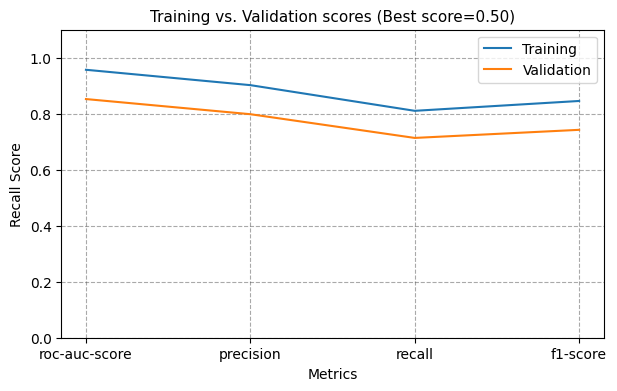

In [54]:
# plot scores
best_score = XGB_search_clf.best_score_
plot_learning_curve(best_score, XGB_score)

- *XGBoost model performance is very similar to Gradient Boosting.*
- *Overall performances was very good, especially in terms of ROC-AUC. However, recall scores is lower for XGBoost as well which might miss some positive cases.*

#### Precision-Recall Curve
Find best threshold for XGBoost Classifier

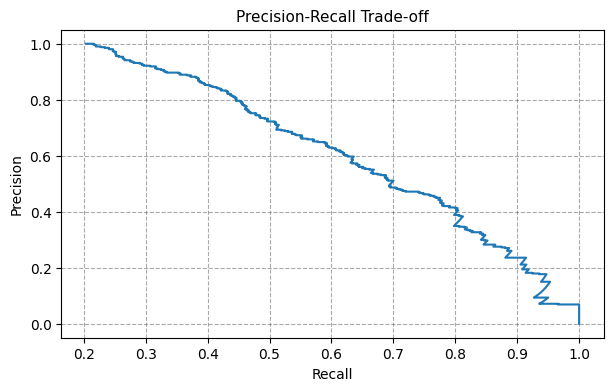

Best of XGBoost Classifier
------------------------------
Precision:: 0.7491471560026735
Recall:: 0.7650562735308498
F1-score:: 0.7564892623716153
Confusion Matrix::
---------------
[[1412  181]
 [ 145  262]]


In [55]:
XGB_best_threshold, y_preds = find_threshold(XGB_model)

# Model performance on best threshold
precision, recall, f1score, cm = get_search_score(y_valid, y_preds, XGB_best_threshold)

print(f"Best of XGBoost Classifier\n{'---'*10}")
print("Precision::", precision)
print("Recall::", recall)
print("F1-score::", f1score)
print(f"Confusion Matrix::\n{'---'*5}")
print(cm)

In [56]:
# Save grid search XGBoost classifer
save_model('XGB_model', XGB_model)

### Random Forest Classifier

In [57]:
# Define default RandomForest Classifier
RF_clf = RandomForestClassifier(max_features='sqrt', class_weight=weights_dict, random_state=42)

In [58]:
# Set parameters of Random forest for GridSearch algorithm
params = {
    'criterion': ['log_loss', 'entropy', 'gini'],
    'n_estimators': [10, 100, 200, 300, 500, 800, 1000, 1200],
    'max_depth': [3, 5, 7],
    'max_samples': [0.6, 0.7, 0.8]
}

# Define search algorithm
RF_search_clf = GridSearchCV(estimator=RF_clf,
                             param_grid=params,
                             scoring='recall',
                             cv=StratifiedKFold(7, shuffle=True, random_state=42),
                             n_jobs=-1,
                             verbose=1,
                             return_train_score=True)

# Fit the search algorithm on training data
RF_search_clf.fit(X_train, y_train)

Fitting 7 folds for each of 216 candidates, totalling 1512 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight={np.int64(0): np.float64(0.6280092108017584),
                                                            np.int64(1): np.float64(2.4529844644317254)},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['log_loss', 'entropy', 'gini'],
                         'max_depth': [3, 5, 7], 'max_samples': [0.6, 0.7, 0.8],
                         'n_estimators': [10, 100, 200, 300, 500, 800, 1000,
                                          1200]},
             return_train_score=True, scoring='recall', verbose=1)

In [59]:
# Examine training and validation scores of Random forest Classifier
RF_CVresults = pd.DataFrame(RF_search_clf.cv_results_)
columns = ['mean_fit_time', 'mean_score_time', 
           'param_criterion', 'param_n_estimators', 'param_max_depth', 'param_max_samples',
           'mean_train_score', 'mean_test_score']

RF_CVresults = RF_CVresults[columns]
RF_CVresults.head()

,mean_fit_time,mean_score_time,param_criterion,param_n_estimators,param_max_depth,param_max_samples,mean_train_score,mean_test_score
0,0.065717,0.009289,log_loss,10,3,0.6,0.694876,0.692550
1,0.522327,0.021289,log_loss,100,3,0.6,0.689152,0.686000
2,1.043826,0.033718,log_loss,200,3,0.6,0.685473,0.681900
3,1.549874,0.045863,log_loss,300,3,0.6,0.683157,0.680263
4,2.558508,0.074149,log_loss,500,3,0.6,0.683157,0.678630


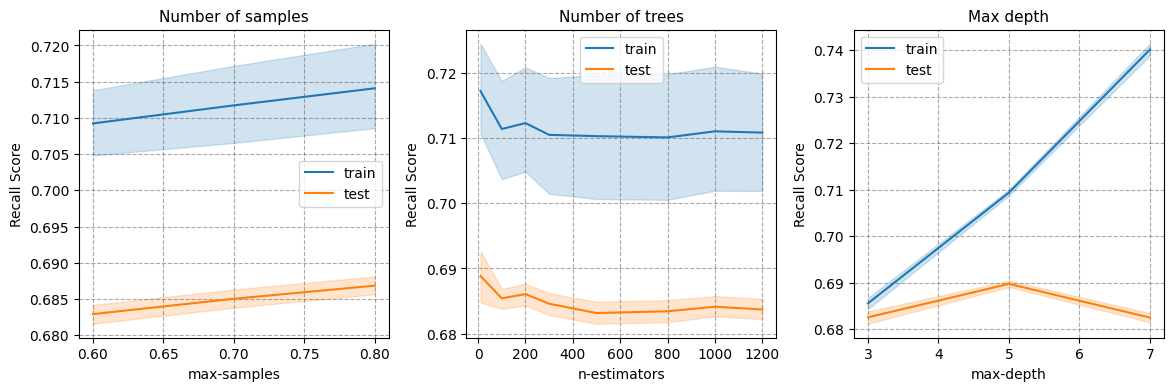

In [60]:
# Plot learning curves
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
fig.subplots_adjust(wspace=0.25)

# plot
sns.lineplot(RF_CVresults, x='param_max_samples', y='mean_train_score', ax=ax1, label='train')
sns.lineplot(RF_CVresults, x='param_max_samples', y='mean_test_score', ax=ax1, label='test')

sns.lineplot(RF_CVresults, x='param_n_estimators', y='mean_train_score', ax=ax2, label='train')
sns.lineplot(RF_CVresults, x='param_n_estimators', y='mean_test_score', ax=ax2, label='test')

sns.lineplot(RF_CVresults, x='param_max_depth', y='mean_train_score', ax=ax3, label='train')
sns.lineplot(RF_CVresults, x='param_max_depth', y='mean_test_score', ax=ax3, label='test')

ax1.set_title("Number of samples", size=11)
ax2.set_title("Number of trees", size=11)
ax3.set_title("Max depth", size=11)

ax1.set_xlabel('max-samples')
ax2.set_xlabel('n-estimators')
ax3.set_xlabel('max-depth')

ax1.set_ylabel('Recall Score')
ax2.set_ylabel('Recall Score')
ax3.set_ylabel('Recall Score')

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5)
ax3.grid(ls='--', color='#555', alpha=0.5)

ax1.legend()
ax2.legend()
ax3.legend();

- *From above plots, we can say there no such difference between training and test roc-auc score of random forest classifier for different values of max-samples and n-estimators.*
- *Although, large values of max-depth tends to overfit the model.*

#### Best model evaluation - Random Forest Classifier

In [61]:
# Evaluate best model on validation data
RF_model = RF_search_clf.best_estimator_
RF_model, RF_score, RF_confusion_matrix = evaluate_search_model(RF_model, 'Random Forest Classifier')

In [63]:
RF_score

,training_score,validation_score
roc-auc-score,0.798478,0.789834
precision,0.653287,0.641954
recall,0.715121,0.703338
f1-score,0.660712,0.645442


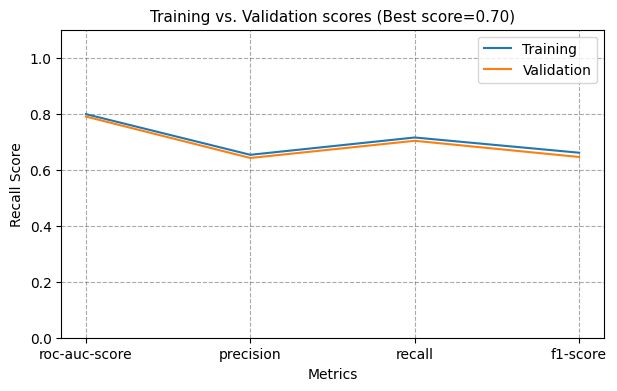

In [64]:
# Examine model performance on validation data using various metrics
best_score = RF_search_clf.best_score_
plot_learning_curve(best_score, RF_score)

In [62]:
score_df

,Classifier,Train-ROC-AUC,Train Precision,Train Recall,Train F1Score,Valid-ROC-AUC,Valid Precision,Valid Recall,Valid F1Score
0,Logistic Regression,0.847319,0.697519,0.769379,0.712970,0.836706,0.689985,0.758955,0.704570
1,KNN,0.944583,0.857719,0.787688,0.815492,0.734269,0.698437,0.661190,0.675292
2,Gradient Boosting Classifier,0.879720,0.832523,0.738524,0.771136,0.854610,0.814129,0.714870,0.747177
3,XGBoost Classifer,0.956962,0.902069,0.810370,0.845542,0.852365,0.798296,0.713560,0.742467
4,Random Forest Classifier,0.798478,0.653287,0.715121,0.660712,0.789834,0.641954,0.703338,0.645442


- *The performance of Random Forest classifier is better than previous models.*
- *The model score high ROC-AUC 0.85 indicates good discriminatory power, with high f1score and Recall of 0.76 meaning 76% of all positive samples captures by model.*

#### Precision-Recall Curve
Find optimal value for threshold using precision-recall curve

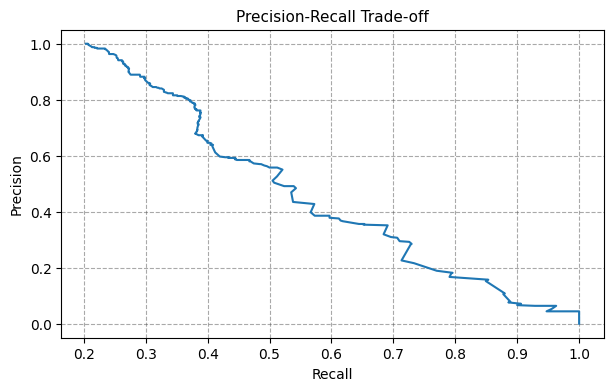

(np.float64(0.6949821254665223),
 np.float64(0.6988691310725209),
 np.float64(0.6968742543545694),
 array([[1389,  204],
        [ 193,  214]]))

In [65]:
RF_best_threshold, y_preds = find_threshold(RF_model)

# Model performance using threshold value
get_search_score(y_valid, y_preds, RF_best_threshold)

In [66]:
# Save grid search random forest model
save_model('RF_model', RF_model)

### Support Vector Machine

In [67]:
# Define classifier
SVM_clf = SVC(class_weight=weights_dict, random_state=42)

In [68]:
# Set parameters of SVM Classifer for GridSearch algorithm
params = {
    'C': [1, 10, 15, 100, 1000],
    'max_iter': [-1, 10, 100, 1000]
}

# Define search algorithm
SVM_search_clf = GridSearchCV(estimator=SVM_clf,
                             param_grid=params,
                             scoring='recall',
                             cv=StratifiedKFold(7, shuffle=True, random_state=42),
                             n_jobs=-1,
                             verbose=1,
                             return_train_score=True)

# Fit the search algorithm on training data
SVM_search_clf.fit(X_train, y_train)

Fitting 7 folds for each of 20 candidates, totalling 140 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=SVC(class_weight={np.int64(0): np.float64(0.6280092108017584),
                                         np.int64(1): np.float64(2.4529844644317254)},
                           random_state=42),
             n_jobs=-1,
             param_grid={'C': [1, 10, 15, 100, 1000],
                         'max_iter': [-1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [69]:
# Examine training and validation scores of Random forest Classifier
SVM_CVresults = pd.DataFrame(SVM_search_clf.cv_results_)
columns = ['mean_fit_time', 'mean_score_time', 
           'param_C', 'param_max_iter', 'mean_train_score', 'mean_test_score']

SVM_CVresults = SVM_CVresults[columns]
SVM_CVresults.head()

,mean_fit_time,mean_score_time,param_C,param_max_iter,mean_train_score,mean_test_score
0,2.239293,0.666912,1,-1,0.820251,0.748168
1,0.038857,0.011717,1,10,0.857688,0.857143
2,0.095864,0.039576,1,100,0.909897,0.921628
3,0.839002,0.328336,1,1000,0.999864,1.000000
4,2.329344,0.590479,10,-1,0.913873,0.674605


#### Best model evaluation - SVM

In [70]:
# Evaluate best model on validation data
SVM_model = SVM_search_clf.best_estimator_
SVM_model, SVM_score, SVM_confusion_matrix = evaluate_search_model(SVM_model, 'Support Vector Classifier')

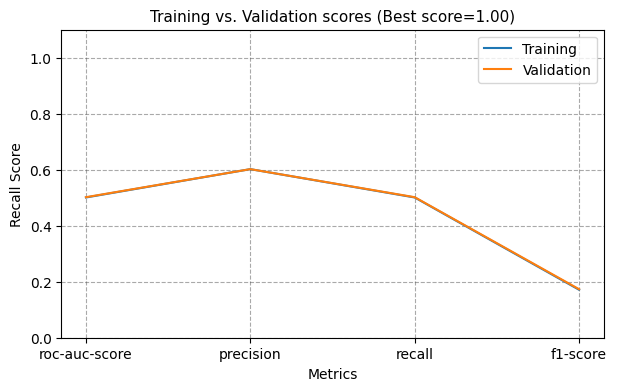

In [72]:
# Examine model performance on validation data using various metrics
best_score = SVM_search_clf.best_score_
plot_learning_curve(best_score, SVM_score)

- *The svm classifier has perfect score on training data. However when it perform poorly when measure on validation data.*

In [71]:
score_df

,Classifier,Train-ROC-AUC,Train Precision,Train Recall,Train F1Score,Valid-ROC-AUC,Valid Precision,Valid Recall,Valid F1Score
0,Logistic Regression,0.847319,0.697519,0.769379,0.712970,0.836706,0.689985,0.758955,0.704570
1,KNN,0.944583,0.857719,0.787688,0.815492,0.734269,0.698437,0.661190,0.675292
2,Gradient Boosting Classifier,0.879720,0.832523,0.738524,0.771136,0.854610,0.814129,0.714870,0.747177
3,XGBoost Classifer,0.956962,0.902069,0.810370,0.845542,0.852365,0.798296,0.713560,0.742467
4,Random Forest Classifier,0.798478,0.653287,0.715121,0.660712,0.789834,0.641954,0.703338,0.645442
5,Support Vector Classifier,0.500837,0.602053,0.500837,0.171180,0.501883,0.602056,0.501883,0.173265


### Ensembles : Gradient boosting, Random Forest, K-Neighbors, Logistic Regression

In [88]:
from sklearn.metrics import accuracy_score

# Evaluate the ensemble on validation data.
lr_preds = LR_model.predict_proba(X_valid)[:, 1]
rf_preds = RF_model.predict_proba(X_valid)[:, 1]
knn_preds = KNN_model.predict_proba(X_valid)[:, 1]
xgb_preds= XGB_model.predict_proba(X_valid)[:, 1]
gbm_preds= GBM_model.predict_proba(X_valid)[:, 1]
svc_preds= XGB_model.predict_proba(X_valid)[:, 1]

# Select the most common prediction
y_preds = (lr_y_preds + rf_y_preds + knn_y_preds + xgb_y_preds ) / 4

# Compute scores at threshold 0.4
roc_score = roc_auc_score(y_valid, y_preds)
precision, recall, f1score, cm = get_search_score(y_valid, y_preds, 0.4)
y_preds = (y_preds > 0.4).astype(int)
accuracy = accuracy_score(y_valid, y_preds)

In [89]:
print("Accuracy ==> %.3f" %accuracy)
print(f"ROC-AUC score ==> {roc_score:.2f}" )
print(f"Precision ==> {precision:.2f}\nRecall ==> {recall:.2f}")
print(f"F1-score ==> {f1score:.2f}\nConfusion Matrix ::\n{cm}")

Accuracy ==> 0.800
ROC-AUC score ==> 0.84
Precision ==> 0.71
Recall ==> 0.77
F1-score ==> 0.73
Confusion Matrix ::
[[1314  279]
 [ 120  287]]
